1. Data Collection
We start by organizing different factors that influence an organization, like rules, strategies, and individual behaviors. These factors are categorized into different levels—big-picture (Macrolevel), organizational (Mesolevel), and individual (Microlevel).

2. Training the Model
We use a Graph Neural Network (GNN) to teach the computer how these factors are connected. The model learns by analyzing examples and identifying patterns in the data.

3. Making Predictions
After training, the GNN predicts the level at which new factors operate (e.g., Macrolevel or Microlevel).

4. Visualizing the Relationships
The model creates a visual network of connected dots. Each dot represents a factor, and the connections between them show how they're related. The colors indicate the level of each factor, making it easy to see the overall structure.

5. Evaluating Accuracy
Finally, we check how well the model performed by measuring its accuracy in predicting the correct levels.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

# Define the data for social engineering variables and subcategories
data = pd.DataFrame({
    'Variable': [
        'Regulatory', 'Domain', 'Strategic', 'Organisational Culture', 'Organisation',
        'Organisational Strategy', 'Individuals', 'Information Source'
    ],
    'Subcategory': [
        ['1.1 Legitimacy', '1.2 Framework'],
        ['2.1 Political', '2.2 Economic', '2.3 Socio-cultural', '2.4 Technological', '2.5 Legal'],
        ['3.1 Fake News', '3.2 Strategies'],
        ['4.1 Optimization', '4.2 Reduction'],
        ['5.1 Capability', '5.2 Innovation', '5.3 Leadership'],
        ['6.1 Social Media', '6.2 Facts'],
        ['7.1 Demographic', '7.2 Personality', '7.3 Self-efficacy', '7.4 Belief', '7.5 Trust'],
        ['8.1 Information Ecosystem', '8.2 Risk', '8.3 Propagation']
    ],
    'Level': [
        'Macrolevel', 'Macrolevel', 'Macrolevel', 'Mesolevel', 'Mesolevel',
        'Mesolevel', 'Microlevel', 'Microlevel'
    ],
    'Scope': [
        'Internal', 'External', 'Internal', 'Internal', 'External',
        'Internal', 'Internal', 'External'
    ]
})

# Encode categories and levels
le_level = LabelEncoder()
le_scope = LabelEncoder()

data['Level_encoded'] = le_level.fit_transform(data['Level'])
data['Scope_encoded'] = le_scope.fit_transform(data['Scope'])

# Prepare the dataset for GNN
X = data[['Level_encoded', 'Scope_encoded']].values
y = data['Level_encoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the GNN model
class GNN(tf.keras.Model):
    def __init__(self, num_classes):
        super(GNN, self).__init__()
        self.embedding = layers.Embedding(input_dim=20, output_dim=16)
        self.attention = layers.Attention()
        self.dense1 = layers.Dense(64, activation='relu')
        self.flatten = layers.Flatten()
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.embedding(inputs)
        attention = self.attention([x, x])
        x = self.dense1(attention)
        x = self.flatten(x)
        return self.dense2(x)

# Initialize and compile the model
model = GNN(num_classes=len(le_level.classes_))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Predict levels for nodes
predictions = model.predict(X)

# Convert predictions to levels
predicted_levels = le_level.inverse_transform(np.argmax(predictions, axis=1))

# Create the graph with predictions
G = nx.Graph()

# Add nodes and edges with predicted levels
for i, row in data.iterrows():
    main_node = row['Variable']
    predicted_level = predicted_levels[i]

    #  main nodes that are added that will show the prediction level
    G.add_node(main_node, level=predicted_level, scope=row['Scope'])

    # subcategories of nodes
    for sub in row['Subcategory']:
        G.add_node(sub, level=row['Level'], scope=row['Scope'])
        G.add_edge(main_node, sub)

# Add levels as nodes and connect them to the appropriate variables
levels = {
    'Macrolevel': ['Regulatory', 'Domain', 'Strategic'],
    'Mesolevel': ['Organisational Culture', 'Organisation', 'Organisational Strategy'],
    'Microlevel': ['Individuals', 'Information Source'],
    'Internal': ['Regulatory', 'Strategic', 'Organisational Culture', 'Organisational Strategy', 'Individuals'],
    'External': ['Domain', 'Organisation', 'Information Source']
}

for level, variables in levels.items():
    G.add_node(level, level=level)
    for variable in variables:
        G.add_edge(level, variable)

# Color Definition
color_map = {
    'Macrolevel': '#FF6347',  # Tomato
    'Mesolevel': '#4682B4',  # SteelBlue
    'Microlevel': '#32CD32',  # LimeGreen
    'Internal': '#8A2BE2',  # BlueViolet
    'External': '#FF8C00'  # DarkOrange
}

# Color assignation to my nodes
node_colors = []
for node in G.nodes():
    node_data = G.nodes[node]
    if 'level' in node_data and node_data['level'] in color_map:
        node_colors.append(color_map[node_data['level']])
    elif 'scope' in node_data and node_data['scope'] in color_map:
        node_colors.append(color_map[node_data['scope']])
    else:
        node_colors.append('#D3D3D3')

#  here i will plot my nodes and graph
def plot_interactive_graph(G):
    pos = nx.spring_layout(G, k=0.5, seed=42, iterations=100)
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_y.append(y0)
        edge_y.append(y1)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        text=[f'{node}<br>Level: {G.nodes[node].get("level", "N/A")}<br>Scope: {G.nodes[node].get("scope", "N/A")}' for node in G.nodes()],
        mode='markers+text',
        textposition='top center',
        marker=dict(size=10, color=[color_map.get(G.nodes[node].get("level", "Undefined"), '#D3D3D3') for node in G.nodes()]),
        hoverinfo='text'
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=0)
                    ))
    fig.update_layout(title="Interactive Social Engineering Variables with GNN Predictions", title_x=0.5)
    fig.show()

plot_interactive_graph(G)

# Summary of model training
print("Training Accuracy:", max(history.history['accuracy']))
print("Validation Accuracy:", max(history.history['val_accuracy']))

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 1.0971 - val_accuracy: 1.0000 - val_loss: 1.0904
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5000 - loss: 1.0954 - val_accuracy: 1.0000 - val_loss: 1.0881
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5000 - loss: 1.0938 - val_accuracy: 1.0000 - val_loss: 1.0856
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8333 - loss: 1.0922 - val_accuracy: 1.0000 - val_loss: 1.0829
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8333 - loss: 1.0907 - val_accuracy: 1.0000 - val_loss: 1.0800
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8333 - loss: 1.0892 - val_accuracy: 1.0000 - val_loss: 1.0774
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8333 - loss: 1.0879 - val_accuracy: 1.0000 - val_loss: 1.0749
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8333 - loss: 1.0865 - val_accuracy: 1.0000 - val_loss: 1.0

Training Accuracy: 0.8333333134651184
Validation Accuracy: 1.0


Project Summary: AI-Driven Social Engineering Risk Model
This code implements an advanced AI-based model to analyze and visualize social engineering risks across organizational levels. Using a Graph Neural Network (GNN), the system processes categorized human-factor variables—like trust, political influence, or leadership—and predicts their influence level (Macro, Meso, or Micro) and scope (Internal or External).

Key outcomes:

Categorical prediction of social engineering risk factors using AI.

Dynamic graph visualization showing variable interconnections and weighted sub-factors.

Clear segmentation by strategic levels and organizational scope.

Model accuracy tracking with training and validation metrics displayed.

Business value: Supports proactive cybersecurity planning and awareness by identifying which human or organizational factors are most vulnerable to social engineering tactics.

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5000 - loss: 1.0988 - val_accuracy: 0.0000e+00 - val_loss: 1.0993
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step - accuracy: 0.5000 - loss: 1.0966 - val_accuracy: 0.5000 - val_loss: 1.0970
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8333 - loss: 1.0945 - val_accuracy: 0.5000 - val_loss: 1.0952
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8333 - loss: 1.0926 - val_accuracy: 0.5000 - val_loss: 1.0937
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8333 - loss: 1.0908 - val_accuracy: 0.5000 - val_loss: 1.0925
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8333 - loss: 1.0890 - val_accuracy: 0.5000 - val_loss: 1.0914
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8333 - loss: 1.0873 - val_accuracy: 0.5000 - val_loss: 1.0900
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8333 - loss: 1.0857 - val_accuracy: 0.5000 - val_loss

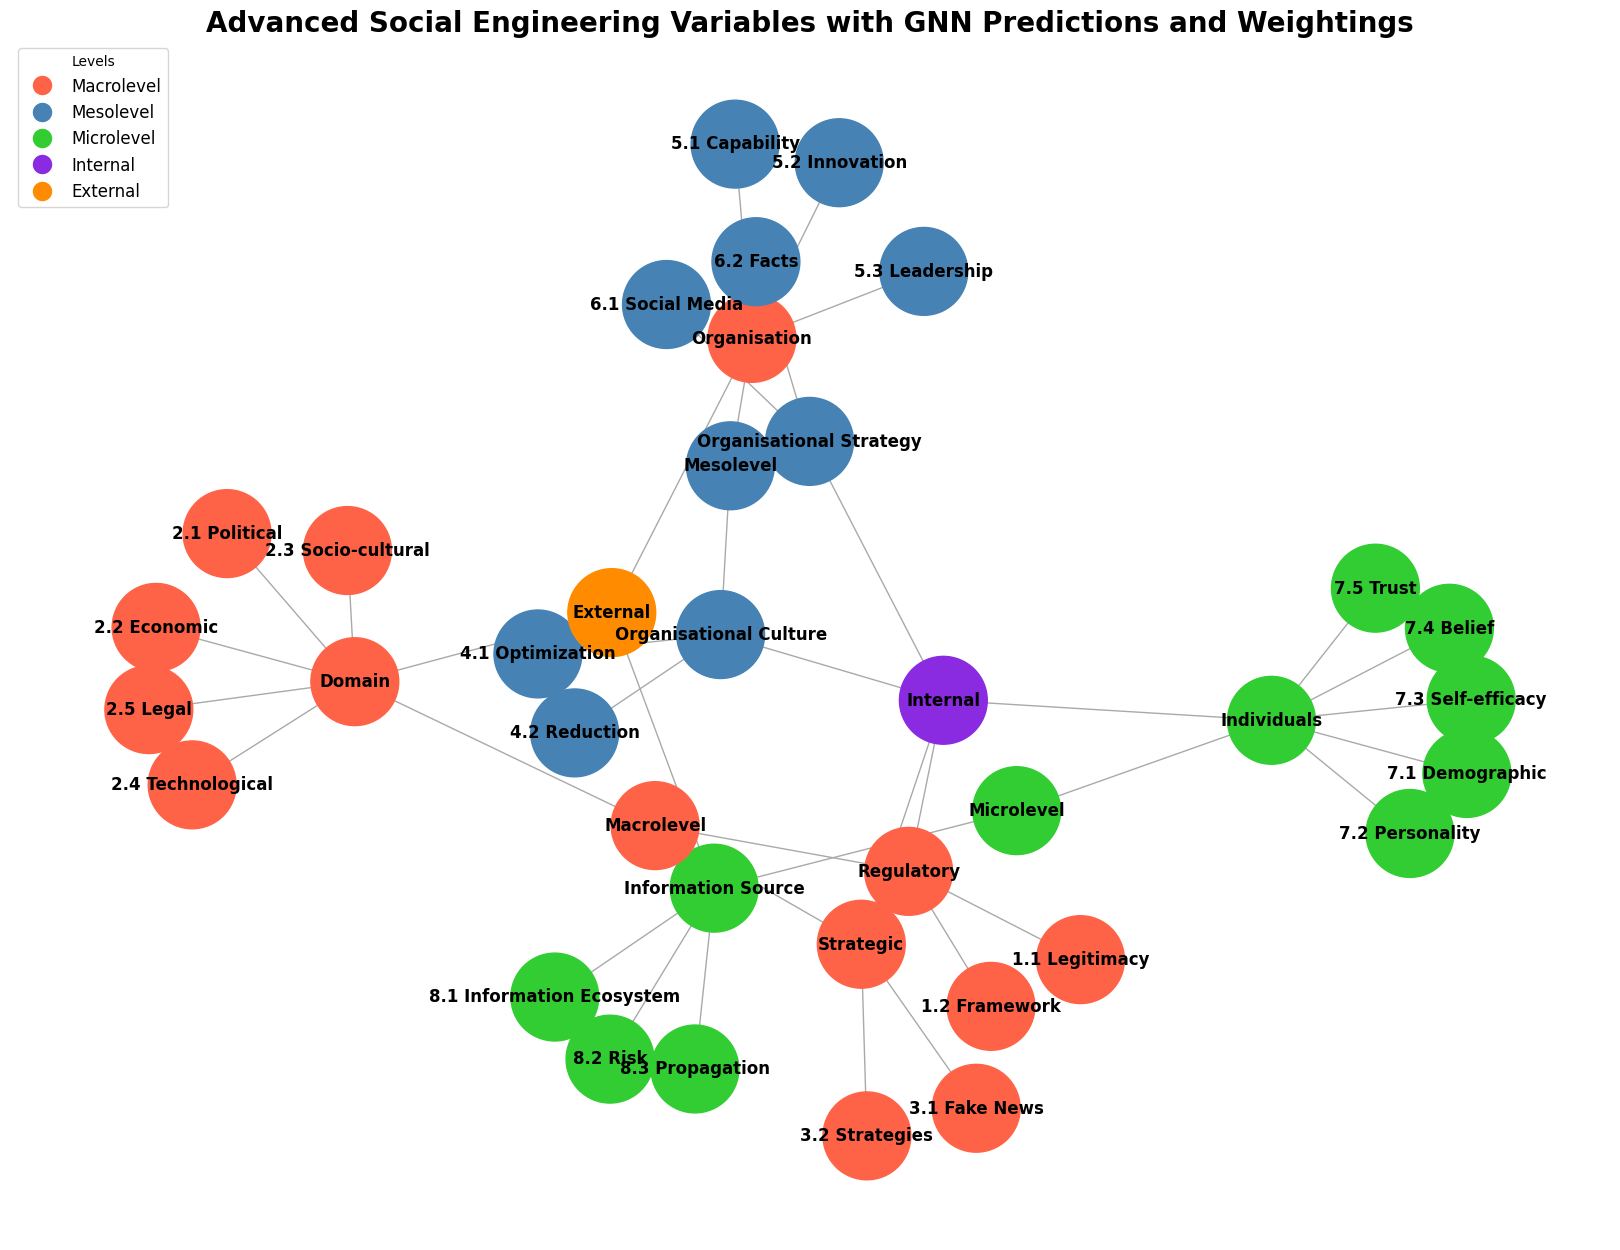

Training Accuracy: 0.8333333134651184
Validation Accuracy: 1.0


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Define the data for social engineering variables and subcategories with weights
data = pd.DataFrame({
    'Variable': [
        'Regulatory', 'Domain', 'Strategic', 'Organisational Culture', 'Organisation',
        'Organisational Strategy', 'Individuals', 'Information Source'
    ],
    'Subcategory': [
        ['1.1 Legitimacy', '1.2 Framework'],
        ['2.1 Political', '2.2 Economic', '2.3 Socio-cultural', '2.4 Technological', '2.5 Legal'],
        ['3.1 Fake News', '3.2 Strategies'],
        ['4.1 Optimization', '4.2 Reduction'],
        ['5.1 Capability', '5.2 Innovation', '5.3 Leadership'],
        ['6.1 Social Media', '6.2 Facts'],
        ['7.1 Demographic', '7.2 Personality', '7.3 Self-efficacy', '7.4 Belief', '7.5 Trust'],
        ['8.1 Information Ecosystem', '8.2 Risk', '8.3 Propagation']
    ],
    'Level': [
        'Macrolevel', 'Macrolevel', 'Macrolevel', 'Mesolevel', 'Mesolevel',
        'Mesolevel', 'Microlevel', 'Microlevel'
    ],
    'Scope': [
        'Internal', 'External', 'Internal', 'Internal', 'External',
        'Internal', 'Internal', 'External'
    ],
    'Variable_weight': [
        0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6
    ],
    'Subcategory_weights': [
        [0.2, 0.2],  # Regulatory sub-variable weights
        [0.08, 0.08, 0.08, 0.08, 0.08],  # Domain sub-variable weights
        [0.2, 0.2],  # Strategic sub-variable weights
        [0.2, 0.2],  # Organisational Culture sub-variable weights
        [0.133, 0.133, 0.133],  # Organisation sub-variable weights
        [0.2, 0.2],  # Organisational Strategy sub-variable weights
        [0.08, 0.08, 0.08, 0.08, 0.08],  # Individuals sub-variable weights
        [0.133, 0.133, 0.133]  # Information Source sub-variable weights
    ]
})

# Encode categories and levels
le_level = LabelEncoder()
le_scope = LabelEncoder()

data['Level_encoded'] = le_level.fit_transform(data['Level'])
data['Scope_encoded'] = le_scope.fit_transform(data['Scope'])

# Prepare the dataset for GNN
X = data[['Level_encoded', 'Scope_encoded']].values
y = data['Level_encoded']  # Example target for prediction

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the GNN model
class GNN(tf.keras.Model):
    def __init__(self, num_classes):
        super(GNN, self).__init__()
        self.embedding = layers.Embedding(input_dim=20, output_dim=16)
        self.attention = layers.Attention()
        self.dense1 = layers.Dense(64, activation='relu')
        self.flatten = layers.Flatten()
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.embedding(inputs)
        attention = self.attention([x, x])
        x = self.dense1(attention)
        x = self.flatten(x)
        return self.dense2(x)

# Initialize and compile the model
model = GNN(num_classes=len(le_level.classes_))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Predict levels for nodes
predictions = model.predict(X)

# Convert predictions to levels
predicted_levels = le_level.inverse_transform(np.argmax(predictions, axis=1))

# Create the graph with predictions
G = nx.Graph()

# Add nodes and edges with predicted levels
for i, row in data.iterrows():
    main_node = row['Variable']
    predicted_level = predicted_levels[i]

    # Add main node with predicted level
    G.add_node(main_node, level=predicted_level, scope=row['Scope'])

    # Add subcategories as nodes connected to their main category
    for j, sub in enumerate(row['Subcategory']):
        sub_weight = row['Subcategory_weights'][j]  # Get the sub-variable weight
        G.add_node(sub, level=row['Level'], scope=row['Scope'], weight=sub_weight)
        G.add_edge(main_node, sub)

# Add levels as nodes and connect them to the appropriate variables
levels = {
    'Macrolevel': ['Regulatory', 'Domain', 'Strategic'],
    'Mesolevel': ['Organisational Culture', 'Organisation', 'Organisational Strategy'],
    'Microlevel': ['Individuals', 'Information Source'],
    'Internal': ['Regulatory', 'Strategic', 'Organisational Culture', 'Organisational Strategy', 'Individuals'],
    'External': ['Domain', 'Organisation', 'Information Source']
}

for level, variables in levels.items():
    G.add_node(level, level=level)
    for variable in variables:
        G.add_edge(level, variable)

# Define colors for levels and scopes
color_map = {
    'Macrolevel': '#FF6347',  # Tomato
    'Mesolevel': '#4682B4',  # SteelBlue
    'Microlevel': '#32CD32',  # LimeGreen
    'Internal': '#8A2BE2',  # BlueViolet
    'External': '#FF8C00'  # DarkOrange
}

# Assign colors to nodes based on their levels and scopes
node_colors = []
for node in G.nodes():
    node_data = G.nodes[node]
    if node_data['level'] in color_map:
        node_colors.append(color_map[node_data['level']])
    elif node_data['scope'] in color_map:
        node_colors.append(color_map[node_data['scope']])
    else:
        node_colors.append('#D3D3D3')  # LightGray for undefined attributes

# Draw the graph with advanced layout
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.5, seed=42, iterations=100)  # More iterations for better layout
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=4000, font_size=12, font_weight='bold', edge_color='#A9A9A9')
plt.title("Advanced Social Engineering Variables with GNN Predictions and Weightings", size=20, fontweight='bold')

# Add a legend for the levels
level_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15, label=level)
                for level, color in color_map.items()]
plt.legend(handles=level_legend, title="Levels", loc='upper left', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Summary of model training
print("Training Accuracy:", max(history.history['accuracy']))
print("Validation Accuracy:", max(history.history['val_accuracy']))